<center>

## Crater Anomaly Simulator

Description: A Jupyter Notebook that simulates the density profile of a crater with the goal of forward modelling the gravity profile of a crater

In [1]:
#import statements
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz

from SimPEG.utils import plot2Ddata, model_builder
from SimPEG import maps
from SimPEG.potential_fields import gravity

### Defining a lunar crater
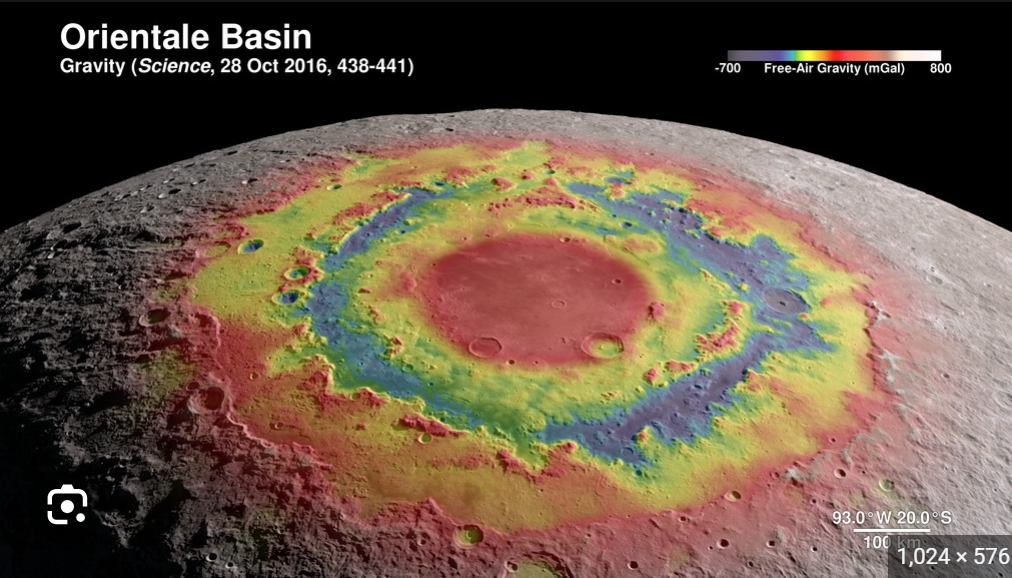

Based on this image, I attempt to define the crater in three scenarios:

1. A simple central depression.
2. A small central "hill" surrounded by a depression.
3. A small central hill surrounded by a depression followed by a secondary uplift.

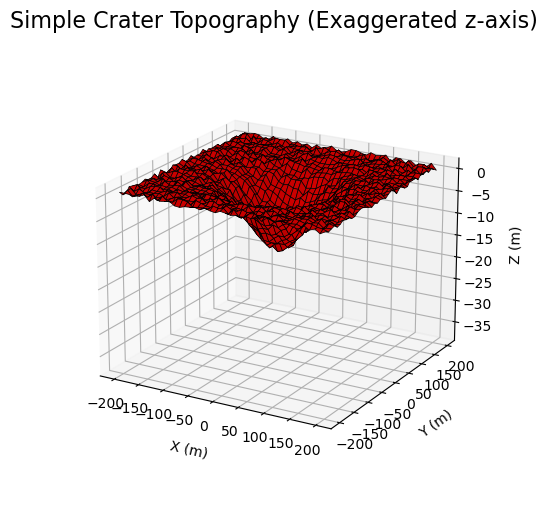

Init signature: TensorMesh(h, origin=None, **kwargs)
Docstring:     
Tensor mesh class.

Tensor meshes are numerical grids whose cell centers, nodes, faces, edges, widths,
volumes, etc... can be directly expressed as tensor products. The axes defining
coordinates of the mesh are orthogonal. And cell properties along one axis do
not vary with respect to the position along any other axis.

Parameters
----------
h : (dim) iterable of int, numpy.ndarray, or tuple
    Defines the cell widths along each axis. The length of the iterable object is
    equal to the dimension of the mesh (1, 2 or 3). For a 3D mesh, the list would
    have the form *[hx, hy, hz]* .

    Along each axis, the user has 3 choices for defining the cells widths:

    - :class:`int` -> A unit interval is equally discretized into `N` cells.
    - :class:`numpy.ndarray` -> The widths are explicity given for each cell
    - the widths are defined as a :class:`list` of :class:`tuple` of the form *(dh, nc, [npad])*
      whe

In [122]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = (
    -15 * np.exp(-(x_topo**2 + y_topo**2) / 80**2)
    + 1.5 * np.random.rand(*x_topo.shape)
)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([z_topo.max() - 40, z_topo.max()])
ax.plot_surface(x_topo, y_topo, z_topo, color="r", edgecolor="k", linewidth=0.5)
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Simple Crater Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=20.0)
z_topo.max()
dh = 5
hz = [(dh, 5, -1.3), (dh, 15)]
hz

TensorMesh?

In [123]:
#Function Cell

def get_mesh_from_topo(x_topo, y_topo, z_topo, n_rec):
    x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
    topo_xyz = np.c_[x_topo, y_topo,z_topo]
    


    # extent_x = 2*x_topo.max() 
    # extent_y = 2*y_topo.max()
    # extent_z = z_topo.max()
    # dx = 5
    # dy = 5
    # dz = 5
    # nx = int(np.ceil(extent_x / dx))
    # ny = int(np.ceil(extent_y / dy))
    # nz = int(np.ceil(extent_z / dz))

    # hx = np.ones(nx) * dx
    # hy = np.ones(ny) * dy
    # hz = np.ones(nz) * dz
    # origin = np.array([-extent_x / 2, -extent_y / 2, 0])
    # mesh = TensorMesh([hx, hy, hz], origin=origin)
    

    dh = 5.0
    dh_z = 1.25
    hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
    hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
    hz = [(dh_z, 5, -1.3)]
    
    mesh = TensorMesh([hx, hy, hz], "CC0")

    # Determine the desired location for the origin
    mesh.origin += np.array([0, 0, z_topo.min()])  # Adjust these coordinates as needed

    # Set the origin of the mesh
   # mesh.origin = origin_location



    print("Origin: {}".format(mesh.origin))


    x_rx = np.linspace(x_topo.min(), x_topo.max(), n_rec)
    y_rx = np.linspace(y_topo.min(), y_topo.max(), n_rec)
    x_rx, y_rx = np.meshgrid(x_rx, y_rx)
    x_rx, y_rx = mkvc(x_rx.T), mkvc(y_rx.T)
    fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
    z_rx = fun_interp(np.c_[x_rx, y_rx]) + 5.0
    z_rx = np.ones_like(x_rx)*100
    receiver_locations = np.c_[x_rx, y_rx, z_rx]

    components = ["gz"]

    receiver_list = gravity.receivers.Point(receiver_locations, components=components)

    receiver_list = [receiver_list]

    source_field = gravity.sources.SourceField(receiver_list=receiver_list)

    survey = gravity.survey.Survey(source_field)
    
    return survey, topo_xyz, mesh, receiver_list

def get_dpred_from_sim(background_density_air, background_density_ground, topo_xyz, mesh, survey):
    # Create density model arrays with appropriate values for ground and air cells
    model_ground = background_density_ground * np.ones(mesh.nC)
    model_air = background_density_air * np.ones(mesh.nC)

    # Define which cells are considered active (both ground and air cells)
    active_cells_all = np.ones(mesh.nC, dtype=bool)

    # Find indices of ground cells below the surface
    active_cells_ground = active_from_xyz(mesh, topo_xyz)

    # Set the density values for ground cells
    model_ground[active_cells_ground == True] = background_density_ground

    # Set the density values for air cells
    model_ground[active_cells_ground == False] = background_density_air

    # Combine density models for ground and air cells
    #model_combined = np.where(active_cells_ground, model_ground, model_air)

    # Create a mapping for the combined density model
    model_map_combined = maps.IdentityMap(nP=mesh.nC)

    # Run simulation for ground and air cells combined
    simulation_all = gravity.simulation.Simulation3DIntegral(
        survey=survey,
        mesh=mesh,
        rhoMap=model_map_combined,
        ind_active=active_cells_all,
        store_sensitivities="forward_only",
    )

    # Calculate predicted data for ground and air cells combined
    dpred_all = simulation_all.dpred(model_ground)
    return dpred_all, active_cells_all, model_ground


# active_cells_ground = active_from_xyz(mesh, topo_xyz)
# nx, ny = 150, 250
# active_cells_ground_2d = active_cells_ground.reshape((nx, ny))

# #print(active_cells_all)
# plt.imshow(active_cells_ground_2d, cmap='binary', interpolation='nearest')
# plt.title('Boolean Array Visualization')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.colorbar(label='True/False')
# plt.show()

# print(active_cells_ground_2d)

In [124]:

# Assign density values for ground and air cells
background_density_ground = 2.0  # Density of ground cells in g/cc
background_density_air = 0.001  # Density of air cells in g/cc



#Calling functions here
survey, topo_xyz, mesh, receiver_list = get_mesh_from_topo(x_topo, y_topo, z_topo, n_rec = 25)

dpred_all, active_cells_all, model_ground = get_dpred_from_sim(background_density_air, 
background_density_ground, topo_xyz, mesh, survey)


mesh


Origin: [-158.78015    -158.78015     -14.90907174]


TensorMesh: 12,500 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     50       -158.78        158.78      5.00     18.56    1.30
   y     50       -158.78        158.78      5.00     18.56    1.30
   z      5        -14.91         -0.21      1.62      4.64    1.30

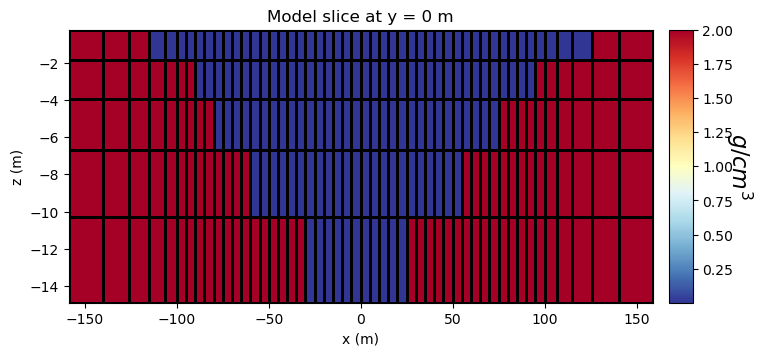

In [125]:
plotting_map = maps.InjectActiveCells(mesh, active_cells_all, np.nan)

fig = plt.figure(figsize=(8, 3.5))

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * model_ground,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(model_ground), np.max(model_ground)),
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.03, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model_ground), vmax=np.max(model_ground))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()



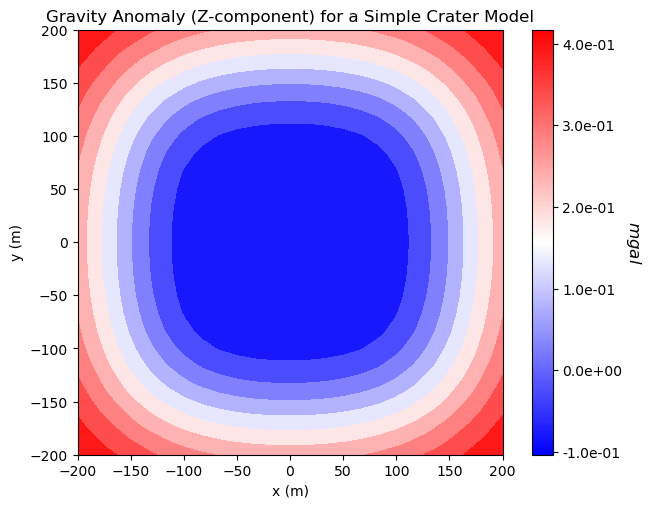

In [126]:
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(receiver_list[0].locations, dpred_all, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly (Z-component) for a Simple Crater Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.82, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.min(np.abs(dpred_all)), vmax=np.max(np.abs(dpred_all)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

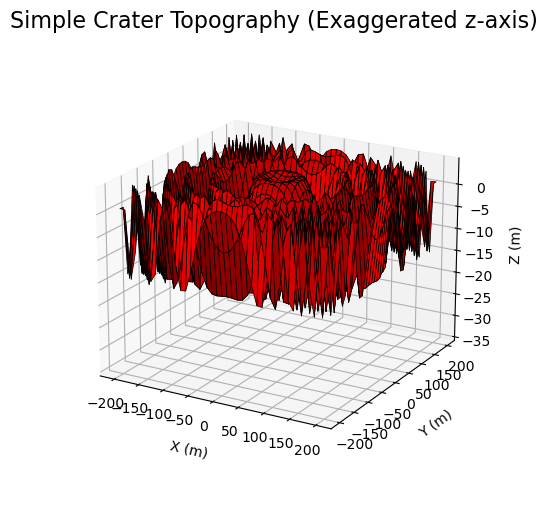

In [117]:
[x_topo1, y_topo1] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))

c = 1000
z_topo1 = (
     10*np.sin(np.sqrt(x_topo1**2 + y_topo1**2 + c**2)) -5
)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([z_topo1.max() - 40, z_topo1.max()])
ax.plot_surface(x_topo1, y_topo1, z_topo1, color="r", edgecolor="k", linewidth=0.5)
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Simple Crater Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=20.0)

In [118]:
#Calling functions here
n_rec1 = 50
background_density_air1 = 0.001
background_density_ground1 = 3.0

survey1, topo_xyz1, mesh1, receiver_list1 = get_mesh_from_topo(x_topo1, y_topo1, z_topo1, n_rec1)

dpred_all1, active_cells_all1, model_ground1  = get_dpred_from_sim(background_density_air1, 
background_density_ground1, topo_xyz1, mesh1, survey1)



Origin: [-158.78015    -158.78015     -14.99936209]


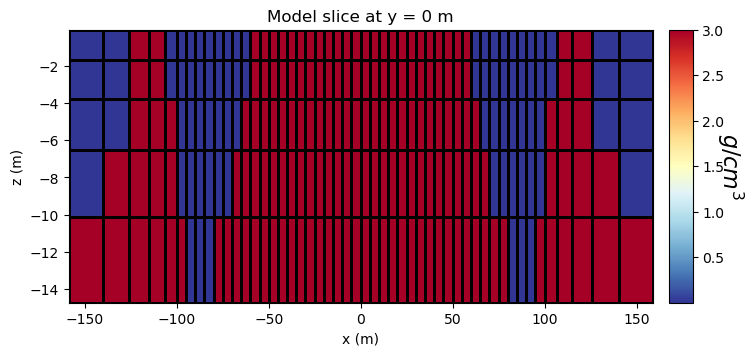

In [119]:
plotting_map = maps.InjectActiveCells(mesh1, active_cells_all1, np.nan)

fig = plt.figure(figsize=(8, 3.5))

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * model_ground1,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(model_ground1), np.max(model_ground1)),
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.03, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model_ground1), vmax=np.max(model_ground1))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()



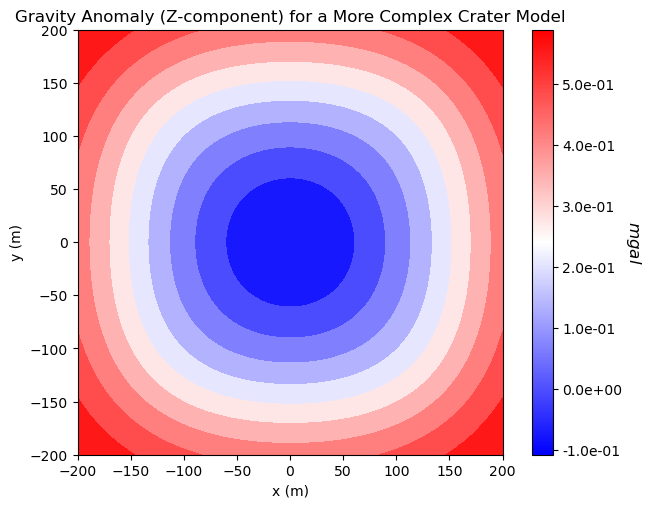

In [121]:
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(receiver_list1[0].locations, dpred_all1, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly (Z-component) for a More Complex Crater Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.82, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.min(np.abs(dpred_all1)), vmax=np.max(np.abs(dpred_all1)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()